# Epidemiologia - esperienza 3

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import emcee
import corner
import scipy.integrate as integrate
import pandas as pd
import seaborn as sns

from typing import List
from collections import Counter
from scipy.integrate import solve_ivp
from scipy.stats import trim_mean
import statsmodels
from statsmodels import robust

%matplotlib inline

In [2]:
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

**Equazione modello SIR**

$$ \frac{\text{d}S}{\text{d}t} = -\beta IS $$
$$ \frac{\text{d}I}{\text{d}t} = \beta IS -\gamma I$$
$$ \frac{\text{d}R}{\text{d}t} = \gamma I$$

## Costruzione del modello

### Download dei dati

In [3]:
original_df = pd.read_csv("/home/elisa/Downloads/owid-covid-data.csv")

In [4]:
original_df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [5]:
work_df = original_df.copy()

In [6]:
work_df.drop(work_df[work_df.iso_code != "ITA"].index, inplace=True)

In [7]:
work_df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
130704,ITA,Europe,Italy,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,27.8,NaN,3.18,83.51,0.892,59037472.0,NaN,NaN,NaN,NaN
130705,ITA,Europe,Italy,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,27.8,NaN,3.18,83.51,0.892,59037472.0,NaN,NaN,NaN,NaN
130706,ITA,Europe,Italy,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,27.8,NaN,3.18,83.51,0.892,59037472.0,-1904.1,-12.37,-12.37,-32.00137


In [8]:
work_df = work_df.reset_index(drop=True)

In [9]:
work_df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,ITA,Europe,Italy,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,27.8,NaN,3.18,83.51,0.892,59037472.0,NaN,NaN,NaN,NaN
1,ITA,Europe,Italy,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,27.8,NaN,3.18,83.51,0.892,59037472.0,NaN,NaN,NaN,NaN
2,ITA,Europe,Italy,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,27.8,NaN,3.18,83.51,0.892,59037472.0,-1904.1,-12.37,-12.37,-32.00137


In [10]:
work_df.to_csv("ITA.csv") 

In [11]:
important = work_df.iloc[[713]]

In [12]:
first = work_df.copy()#correggere
first = first.drop(first[first.index > 793].index)
first = first.drop(first[first.index < 714].index)
first.reset_index(drop=True)
print(len(first))
second = work_df.copy()
second = second.drop(second[second.index < 793].index)
second = second.drop(second[second.index > 878].index)
second.reset_index(drop=True)
print(len(second))

80
86


In [13]:
small_df = work_df.copy() 

In [14]:
small_df = small_df.drop(small_df[small_df.index < 714].index)

In [15]:
small_df = small_df.drop(small_df[small_df.index > 878].index)

In [16]:
small_df = small_df.reset_index(drop=True)

In [17]:
small_df.to_csv("data.csv")

In [18]:
working = small_df.copy()

In [19]:
working = working.drop(['stringency_index', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'population', 'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_per_million'], axis=1)

In [20]:
working = working.drop(['icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred', 'new_vaccinations_smoothed_per_million', 'new_people_vaccinated_smoothed', 'new_people_vaccinated_smoothed_per_hundred'], axis=1)

In [21]:
working.to_csv("reduced_data.csv")

In [22]:
working.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate
0,ITA,Europe,Italy,2021-12-17,5308180.0,26104.0,20485.714,135301.0,123.0,107.143,89912.048,442.160,346.995,2291.782,2.083,1.815,1.32
1,ITA,Europe,Italy,2021-12-18,5336795.0,28615.0,21646.429,135421.0,120.0,107.429,90396.740,484.692,366.656,2293.814,2.033,1.820,1.35
2,ITA,Europe,Italy,2021-12-19,5364852.0,28057.0,22649.571,135544.0,123.0,111.286,90871.980,475.241,383.647,2295.898,2.083,1.885,1.38


## Inferenza Bayesiana

Da qui in avanti il dataset principale di lavoro diventa "working" che è un dataset ridotto contenente solamente alcune informazioni circa l'andamento dei contagi (e nessuna informazione demografica sui contagiati).
Si noti che nel seguito la popolazione N viene considerata costante con $$ N = 58983122. $$
Per comodità di lavoro aggiuno al dataset una colonna in cui riporto l'incidenza a partire dai nuovi casi, in epidemiologia infatti, l'incidenza è definita come rapporto tra i nuovi casi e la popolazione.

Il valore di N che ho utilizzato nel seguito è arrotondato rispetto all'ordine di grandezza dei nuovi casi

In [23]:
N=important["population"][713]
print(N)

59037472.0


**Costruzione del modello**

Il prior è assunto uniforme tra 0 e 1, le misure sono misure di conteggio quindi verrà utilizzata una distribuzione poissoniana
$$
    P_\lambda(n)=\frac{\lambda^n}{n!}e^{-\lambda}
$$
dove $\lambda$ rappresenta il valore atteso i-esimo (quindi la previsione ottenuta dal modello per l'istante $t_i$ e $n$ rappresenta il dato i-esimo (ovvero il dato degli infetti per l'istante $t_i$).

Dato che i dati sono indipendenti?
$$
\log{P_\lambda(n)} = \log{e^{-\lambda}} + \log{\lambda^n} - \log{n!}
$$
Dato che $n>>1$ posso utilizzare l'approssimazione di Stirling
$$
\log{P_\lambda(n)} = -\lambda\log{e} + n\log{\lambda} - n\log{n} + n = n -\lambda +n\log{\lambda} -n\log{n}
$$


In [24]:
lims_up = np.array([10.0, 10.0]) 
lims_down = np.array([0.0, 0.0])

In [25]:
#questi non la prima riga della tabella di dati che decidiamo di usare
R0 = important["total_cases"][713] - important["new_cases"][713]
I0 = important["new_cases"][713]
S0 = N - I0 - R0

In [26]:
r_data = (working["total_cases"]-working["new_cases"])/N
i_data = working["new_cases"]/N
s_data = 1 - i_data - r_data

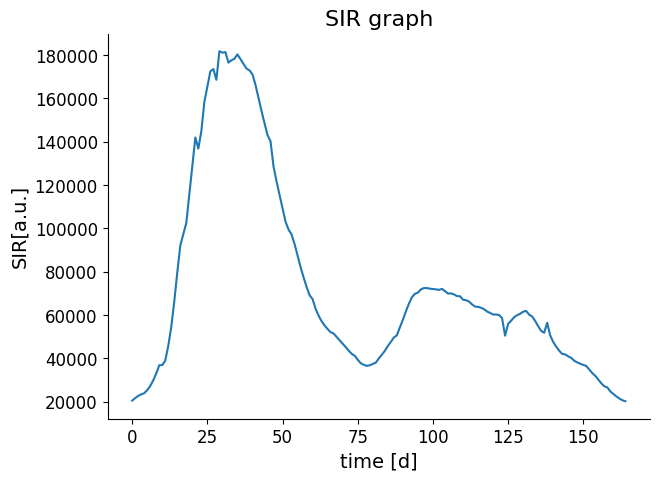

In [27]:
plt.figure(figsize=(7,5))
plt.plot(working["new_cases_smoothed"], label = "i")
plt.xlabel("time [d]")
plt.ylabel("SIR[a.u.]")
plt.title("SIR graph")
#plt.legend(loc=(1, 0.5), frameon=True)
plt.show()

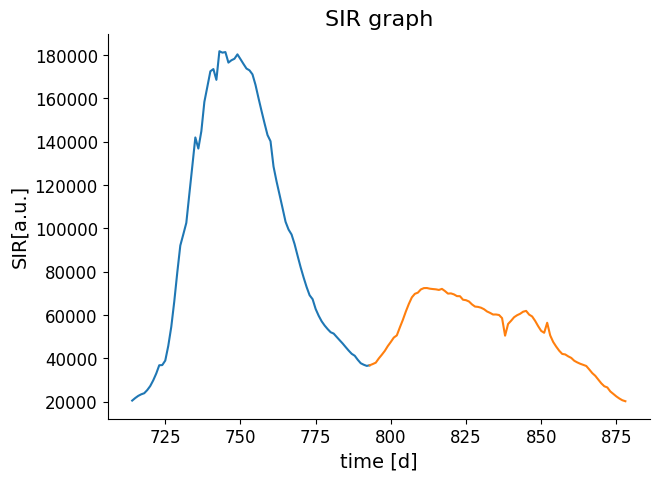

In [32]:
plt.figure(figsize=(7,5))
plt.plot(first["new_cases_smoothed"], label = "first")
plt.plot(second["new_cases_smoothed"], label = "second")
plt.xlabel("time [d]")
plt.ylabel("SIR[a.u.]")
plt.title("SIR graph")
#plt.legend(loc=(1, 0.5), frameon=True)
plt.show()

In [28]:
def SIR_step(S, I, R, N, beta, gamma):
    S = S - beta * S * I / N
    I = I + beta * S * I / N - gamma * I
    R = R + gamma * I
    return S, I, R


def sir_model(S0, I0, R0, N, beta, gamma, nsteps):
    S = [S0]
    I = [I0]
    R = [R0]
    for i in range(0, nsteps-1):
        S_t, I_t, R_t = SIR_step(S[i], I[i], R[i], N, beta, gamma)
        S.append(S_t)
        I.append(I_t)
        R.append(R_t)
    return S, I, R


def loglike(args, S0, I0, R0, nsteps, N, data):
    beta, gamma = args
    S, I, R = sir_model(S0, I0, R0, N, beta, gamma, nsteps)
    sum = 0
    for i in range(len(data)):
        if i < len(I) and I[i] > 0:
            sum += data[i]*(np.log(I[i]) - np.log(data[i])) + data[i] - I[i]
    return sum


def logprior(args):
    beta, gamma = args
    if lims_down[0] < beta < lims_up[0] and lims_down[1] < gamma < lims_up[1]:
        return 0
    else:
        return -np.inf


def logpost(args, S0, I0, R0, nsteps, N, data):
    lp = logprior(args)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(args, S0, I0, R0, nsteps, N, data)

**Inferenza sui parametri**

In [29]:
nwalkers, ndim = 15, 2

posiz = np.array([0.0, 0.0]) + np.random.rand(nwalkers, ndim) * np.array([1.0, 1.0])
posiz.shape

(15, 2)

In [30]:
nsteps = len(working)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=(S0, I0, R0, nsteps, N, working["new_cases"]))
sampler.run_mcmc(posiz, 4000, progress=True);

100%|██████████| 4000/4000 [01:07<00:00, 59.08it/s]


**Plot grafici**

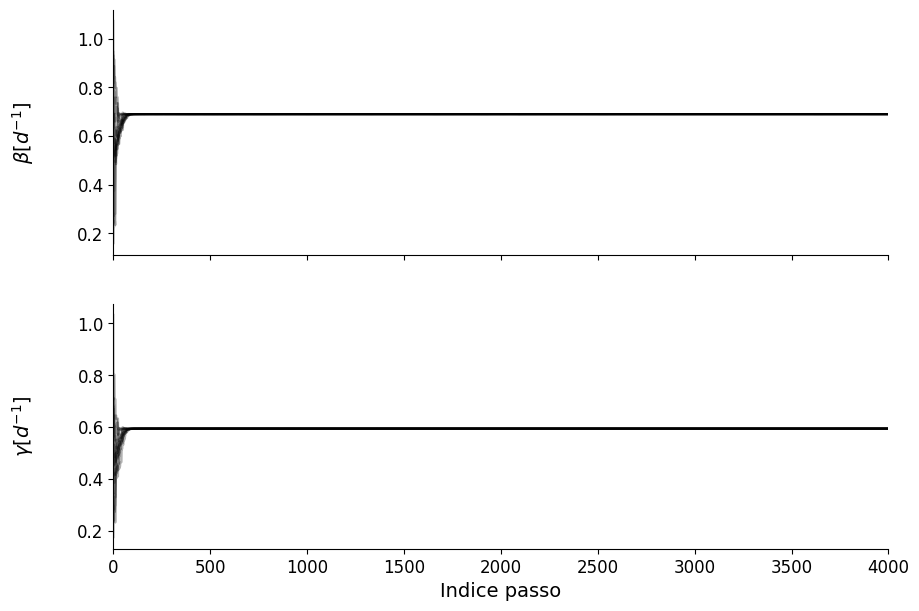

In [33]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\beta [d^{-1}]$", r"$\gamma [d^{-1}]$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Indice passo");

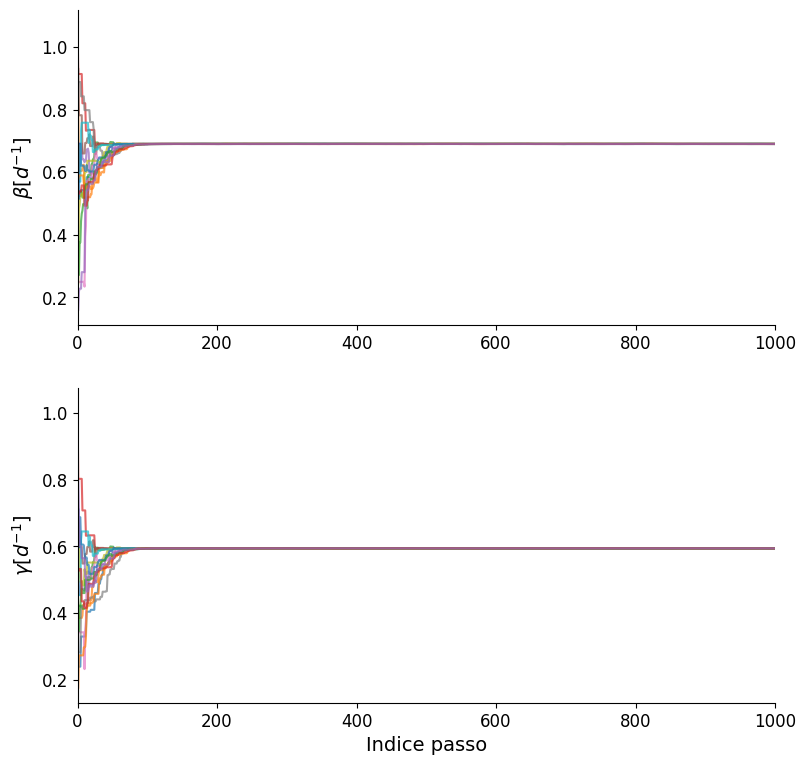

In [34]:
fig, axes = plt.subplots(figsize = (9, 9), ncols = 1, nrows = ndim)

for i in range(ndim):
    for k in range(nwalkers):
        axes[i].plot(samples[:1000, k, i], alpha=0.7)
    axes[i].set_xlim(0, 1000)
    axes[i].set_ylabel(labels[i])

axes[-1].set_xlabel("Indice passo")
plt.show()

Quantiles:
[(0.025, 0.6901175776985692), (0.5, 0.6903611243391202), (0.975, 0.6906011640872489)]
Quantiles:
[(0.025, 0.5940005379953524), (0.5, 0.5942106126257338), (0.975, 0.594416774120393)]


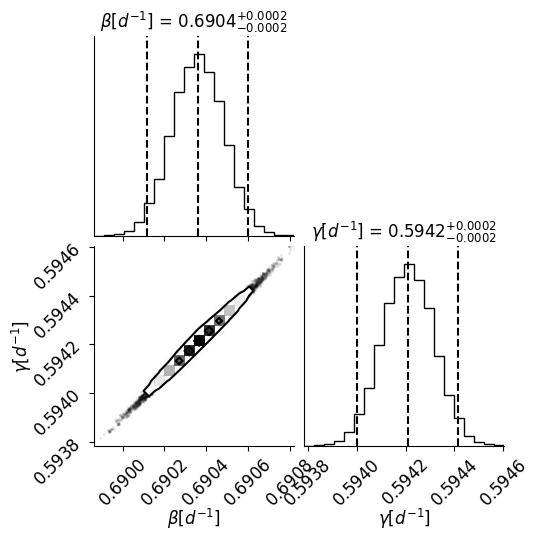

In [35]:
# With sampler.get_chain we get the MCMC chain: we discard the first 600 steps in the chain (burn-in phase), and set 
# thin = 2, i.e. the points are taken every 2 steps (default is 1). 

flat_samples = sampler.get_chain(discard=600, thin=2, flat=True)
fig = corner.corner(flat_samples, 
                    labels=labels,
                    label_kwargs={"fontsize": 12},
                    verbose = True,
                    plot_contours = True,
                    use_math_text = True,
                    quantiles = [0.025, 0.5, 0.975], 
                    title_kwargs={"fontsize": 12},
                    show_titles=True,
                    title_fmt = '.4f');

**Plot andamento delle curve**

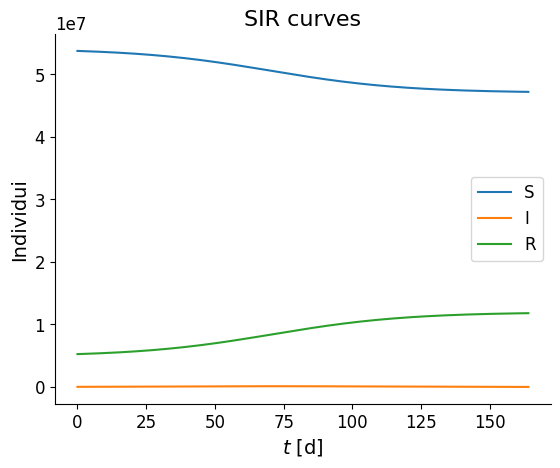

In [39]:
beta=0.69
gamma= 0.59
nsteps=len(working)
S, I, R = sir_model(S0, I0, R0, N, beta, gamma, nsteps)
plt.plot(S, label="S")
plt.plot(I, label="I")
plt.plot(R, label="R")
plt.xlabel(r"$t$ [d]")
plt.ylabel("Individui")
plt.title("SIR curves")
plt.legend()
plt.show()

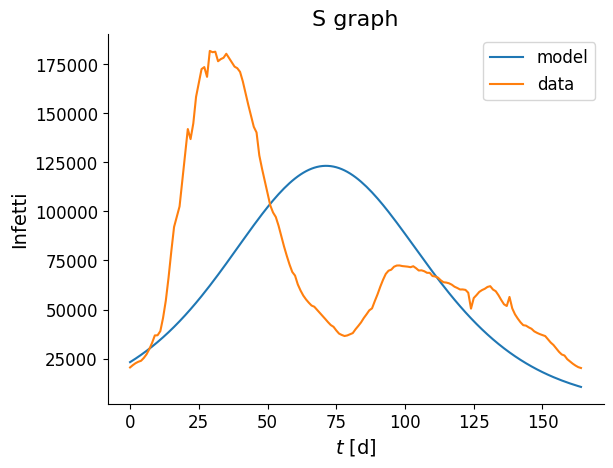

In [40]:
plt.plot(I, label="model")
plt.plot(working["new_cases_smoothed"], label = "data")
plt.xlabel(r"$t$ [d]")
plt.ylabel("Infetti")
plt.title("S graph")
plt.legend()
plt.show()

### Inferenza su casi smoothed

In [41]:
nwalkers, ndim = 15, 2

posiz = np.array([0.0, 0.0]) + np.random.rand(nwalkers, ndim) * np.array([1.0, 1.0])
posiz.shape

(15, 2)

In [50]:
nsteps = len(working)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=(S0, I0, R0, nsteps, N, working["new_cases_smoothed"]))
sampler.run_mcmc(posiz, 4000, progress=True);

100%|██████████| 4000/4000 [01:06<00:00, 60.43it/s]


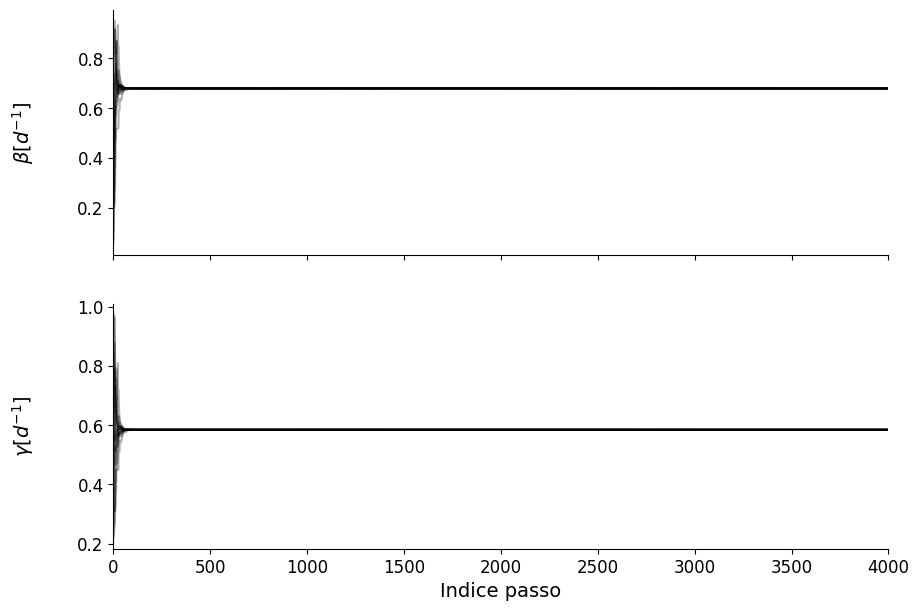

In [51]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\beta [d^{-1}]$", r"$\gamma [d^{-1}]$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Indice passo");

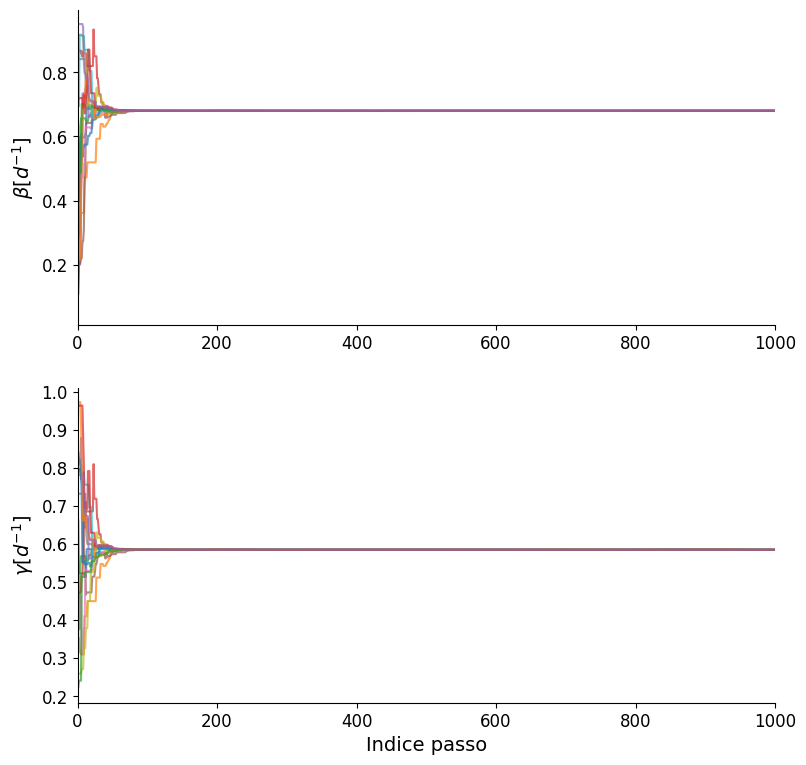

In [52]:
fig, axes = plt.subplots(figsize = (9, 9), ncols = 1, nrows = ndim)

for i in range(ndim):
    for k in range(nwalkers):
        axes[i].plot(samples[:1000, k, i], alpha=0.7)
    axes[i].set_xlim(0, 1000)
    axes[i].set_ylabel(labels[i])

axes[-1].set_xlabel("Indice passo")
plt.show()

Quantiles:
[(0.025, 0.6793286676888405), (0.5, 0.6795599326154219), (0.975, 0.6797949201194421)]
Quantiles:
[(0.025, 0.5843655134468058), (0.5, 0.5845621955673878), (0.975, 0.5847631750066538)]


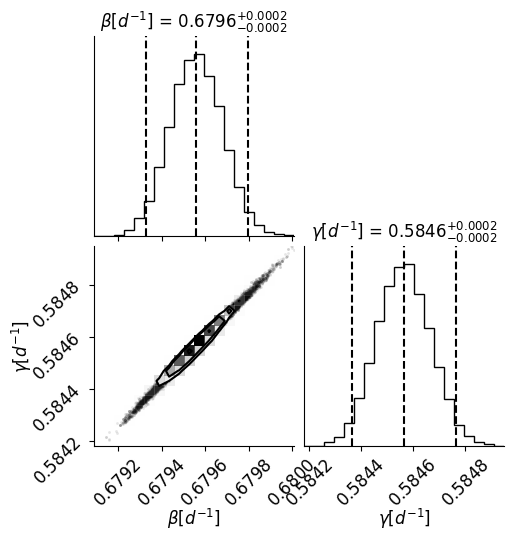

In [53]:
# With sampler.get_chain we get the MCMC chain: we discard the first 600 steps in the chain (burn-in phase), and set 
# thin = 2, i.e. the points are taken every 2 steps (default is 1). 

flat_samples = sampler.get_chain(discard=600, thin=2, flat=True)
fig = corner.corner(flat_samples, 
                    labels=labels,
                    label_kwargs={"fontsize": 12},
                    verbose = True,
                    plot_contours = True,
                    use_math_text = True,
                    quantiles = [0.025, 0.5, 0.975], 
                    title_kwargs={"fontsize": 12},
                    show_titles=True,
                    title_fmt = '.4f');

**Andamento delle curve**

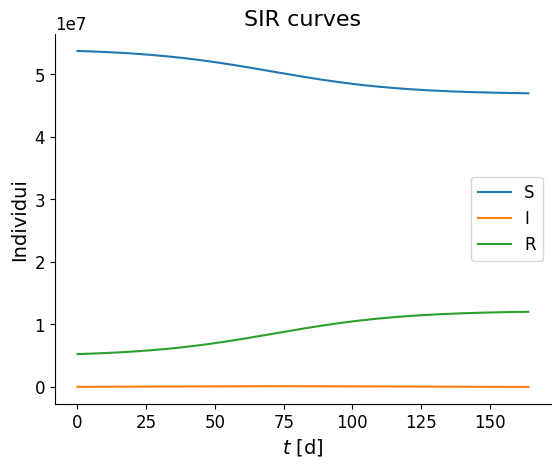

In [54]:
beta=0.68
gamma= 0.58
nsteps=len(working)
S, I, R = sir_model(S0, I0, R0, N, beta, gamma, nsteps)
plt.plot(S, label="S")
plt.plot(I, label="I")
plt.plot(R, label="R")
plt.xlabel(r"$t$ [d]")
plt.ylabel("Individui")
plt.title("SIR curves")
plt.legend()
plt.show()

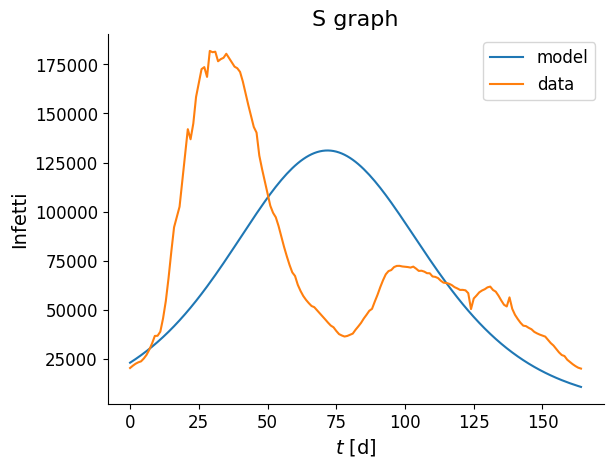

In [55]:
plt.plot(I, label="model")
plt.plot(working["new_cases_smoothed"], label = "data")
plt.xlabel(r"$t$ [d]")
plt.ylabel("Infetti")
plt.title("S graph")
plt.legend()
plt.show()

### Inferenza su picchi separati 

**Primo picco**

In [66]:
working = working.drop(working[working.index>80].index)
workig = working.reset_index(drop=True)

In [104]:
lims_up = np.array([10.0, 10.0]) 
lims_down = np.array([0.0, 0.0])

In [111]:
nwalkers, ndim = 15, 2

posiz = np.array([0.0, 0.0]) + np.random.rand(nwalkers, ndim) * np.array([1.0, 1.0])
posiz.shape

(15, 2)

In [112]:
nsteps = len(working)
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=(S0, I0, R0, nsteps, N, working["new_cases"]))
sampler.run_mcmc(posiz, 4000, progress=True);

100%|██████████| 4000/4000 [00:32<00:00, 123.96it/s]


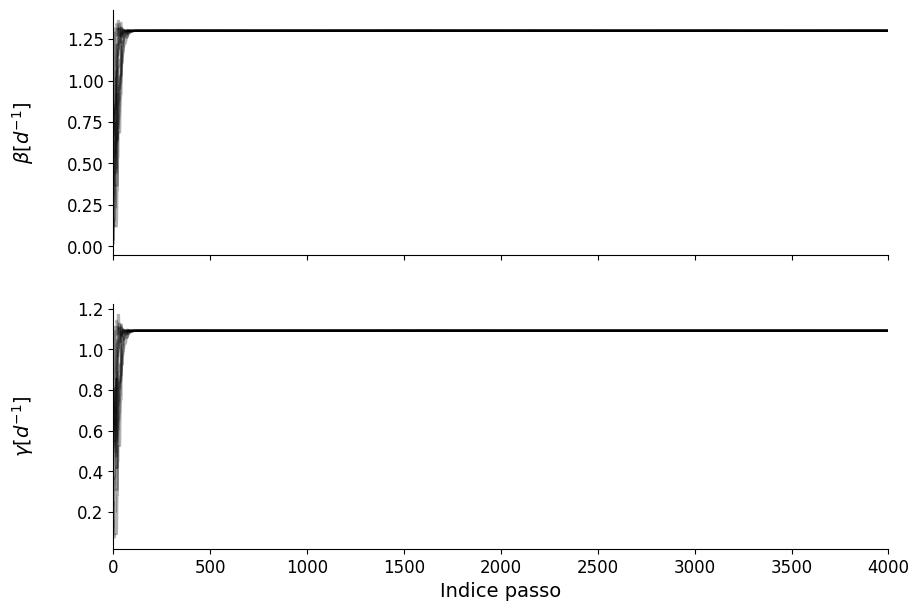

In [113]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\beta [d^{-1}]$", r"$\gamma [d^{-1}]$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Indice passo");

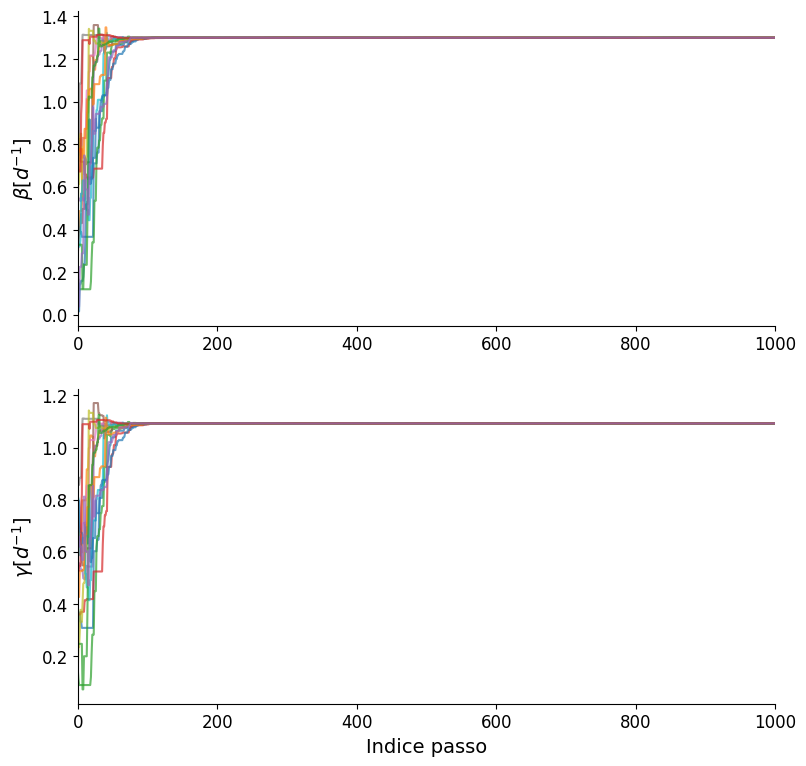

In [114]:
fig, axes = plt.subplots(figsize = (9, 9), ncols = 1, nrows = ndim)

for i in range(ndim):
    for k in range(nwalkers):
        axes[i].plot(samples[:1000, k, i], alpha=0.7)
    axes[i].set_xlim(0, 1000)
    axes[i].set_ylabel(labels[i])

axes[-1].set_xlabel("Indice passo")
plt.show()

Quantiles:
[(0.025, 1.2997346687972033), (0.5, 1.3001580736942602), (0.975, 1.3006055843902855)]
Quantiles:
[(0.025, 1.0920140195858572), (0.5, 1.0923838590624215), (0.975, 1.092771334344216)]


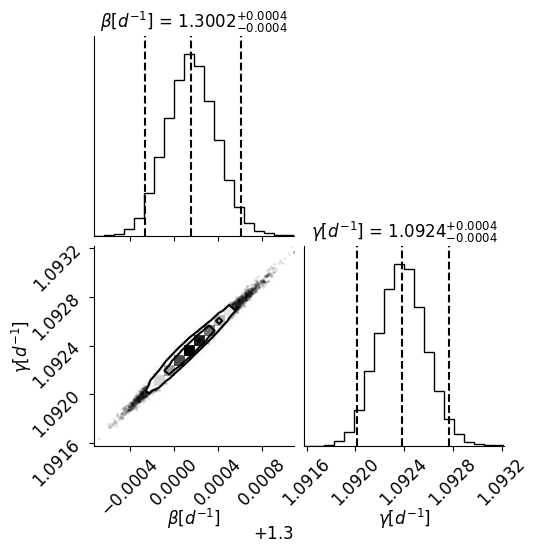

In [115]:
# With sampler.get_chain we get the MCMC chain: we discard the first 600 steps in the chain (burn-in phase), and set 
# thin = 2, i.e. the points are taken every 2 steps (default is 1). 

flat_samples = sampler.get_chain(discard=600, thin=2, flat=True)
fig = corner.corner(flat_samples, 
                    labels=labels,
                    label_kwargs={"fontsize": 12},
                    verbose = True,
                    plot_contours = True,
                    use_math_text = True,
                    quantiles = [0.025, 0.5, 0.975], 
                    title_kwargs={"fontsize": 12},
                    show_titles=True,
                    title_fmt = '.4f');

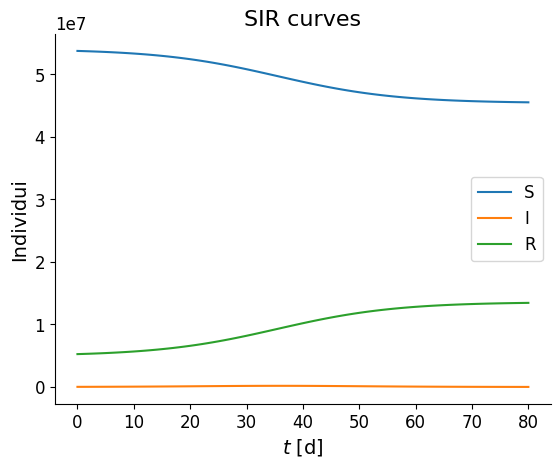

In [116]:
beta=1.302
gamma= 1.0924
nsteps=len(working)
S, I, R = sir_model(S0, I0, R0, N, beta, gamma, nsteps)
plt.plot(S, label="S")
plt.plot(I, label="I")
plt.plot(R, label="R")
plt.xlabel(r"$t$ [d]")
plt.ylabel("Individui")
plt.title("SIR curves")
plt.legend()
plt.show()

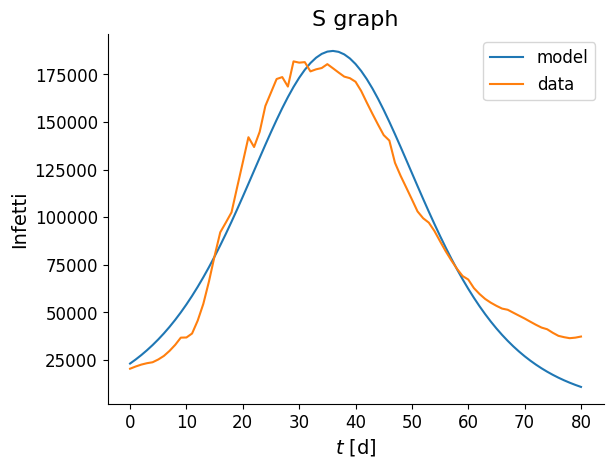

In [117]:
plt.plot(I, label="model")
plt.plot(working["new_cases_smoothed"], label = "data")
plt.xlabel(r"$t$ [d]")
plt.ylabel("Infetti")
plt.title("S graph")
plt.legend()
plt.show()

**Secondo picco**

In [122]:
working = working.drop(working[working.index<80].index)
working = working.reset_index(drop=True)

In [123]:
nsteps = len(working)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=(S0, I0, R0, nsteps, N, working["new_cases"]))
sampler.run_mcmc(posiz, 4000, progress=True);

100%|██████████| 4000/4000 [00:33<00:00, 120.45it/s]


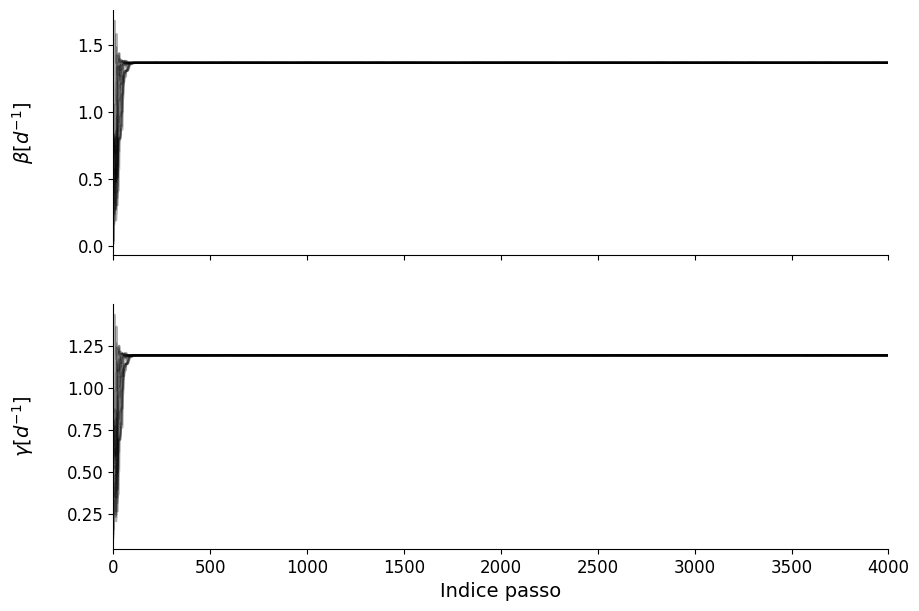

In [124]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\beta [d^{-1}]$", r"$\gamma [d^{-1}]$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Indice passo");

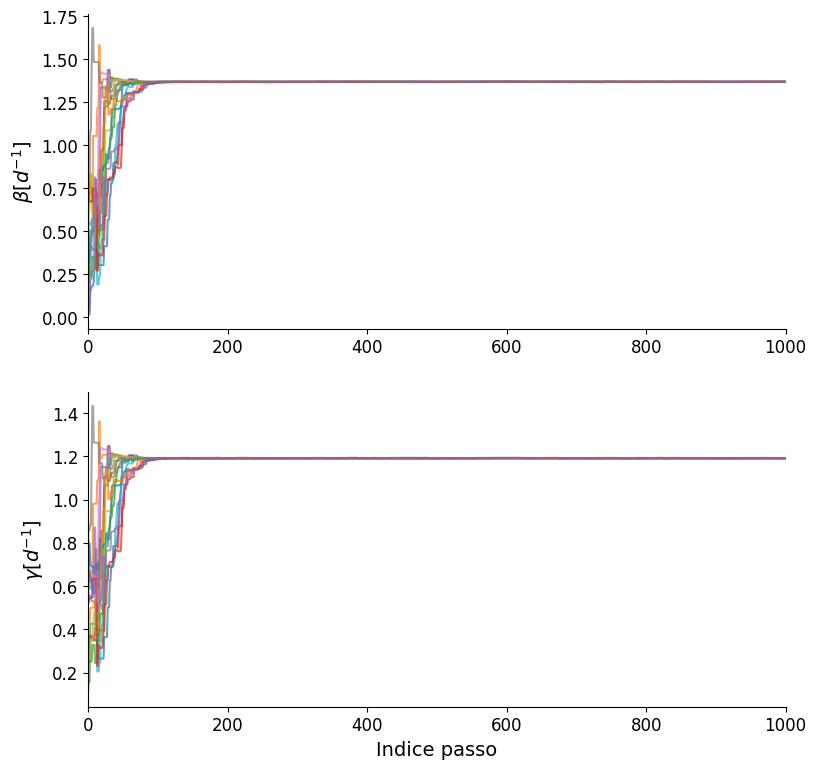

In [125]:
fig, axes = plt.subplots(figsize = (9, 9), ncols = 1, nrows = ndim)

for i in range(ndim):
    for k in range(nwalkers):
        axes[i].plot(samples[:1000, k, i], alpha=0.7)
    axes[i].set_xlim(0, 1000)
    axes[i].set_ylabel(labels[i])

axes[-1].set_xlabel("Indice passo")
plt.show()

Quantiles:
[(0.025, 1.367936550921888), (0.5, 1.3687842747539793), (0.975, 1.3696262868216913)]
Quantiles:
[(0.025, 1.191146696258152), (0.5, 1.1918785333782087), (0.975, 1.192600538942358)]


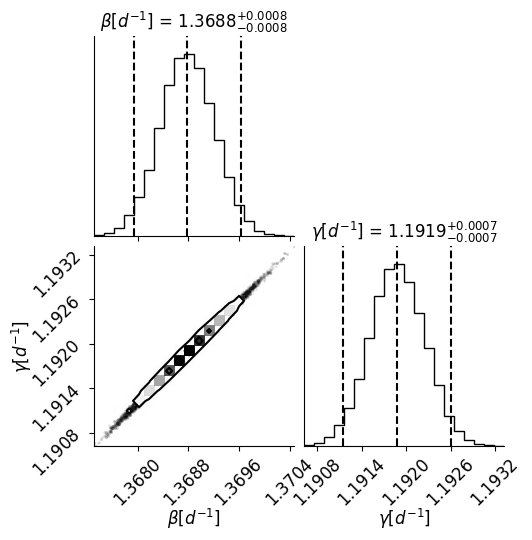

In [126]:
# With sampler.get_chain we get the MCMC chain: we discard the first 600 steps in the chain (burn-in phase), and set 
# thin = 2, i.e. the points are taken every 2 steps (default is 1). 

flat_samples = sampler.get_chain(discard=600, thin=2, flat=True)
fig = corner.corner(flat_samples, 
                    labels=labels,
                    label_kwargs={"fontsize": 12},
                    verbose = True,
                    plot_contours = True,
                    use_math_text = True,
                    quantiles = [0.025, 0.5, 0.975], 
                    title_kwargs={"fontsize": 12},
                    show_titles=True,
                    title_fmt = '.4f');

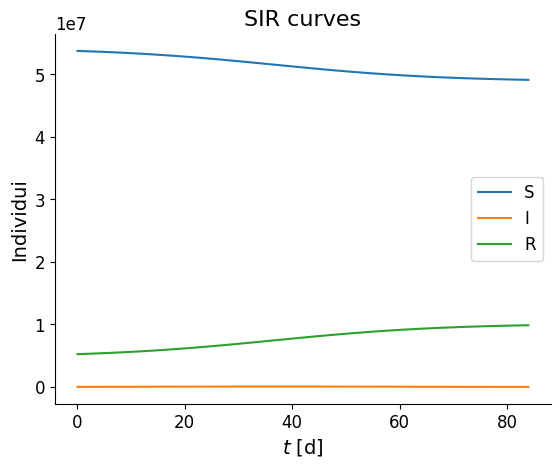

In [127]:
beta=1.3668
gamma=1.1919
nsteps=len(working)
S, I, R = sir_model(S0, I0, R0, N, beta, gamma, nsteps)
plt.plot(S, label="S")
plt.plot(I, label="I")
plt.plot(R, label="R")
plt.xlabel(r"$t$ [d]")
plt.ylabel("Individui")
plt.title("SIR curves")
plt.legend()
plt.show()

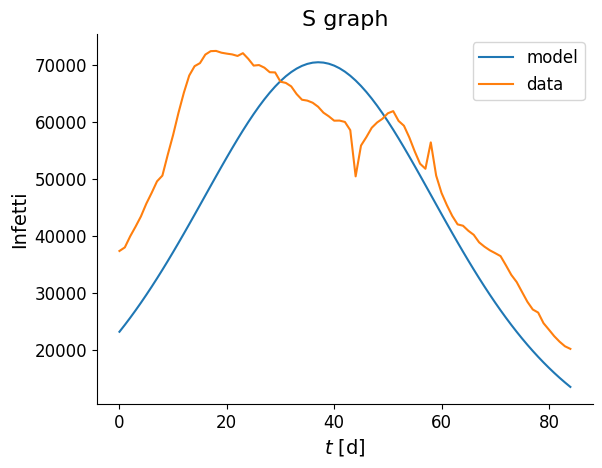

In [128]:
plt.plot(I, label="model")
plt.plot(working["new_cases_smoothed"], label = "data")
plt.xlabel(r"$t$ [d]")
plt.ylabel("Infetti")
plt.title("S graph")
plt.legend()
plt.show()